生成基金特征...
获取基金004746数据，共1980条记录
获取沪深300指数数据，共5710条记录
特征生成完成，数据形状: (1904, 65)
数据形状: (1904, 59)
使用滚动窗口训练模型...

=== 模型评估结果 ===
               Model  Avg Train R²    Avg Val R²           MAE          RMSE
2      Random Forest        0.9739 -6.272000e+00  2.740000e-02  3.810000e-02
4            XGBoost        0.9998 -6.351800e+00  2.700000e-02  3.810000e-02
3           LightGBM        0.9827 -6.770600e+00  2.760000e-02  3.770000e-02
1   Ridge Regression        0.6169 -9.883900e+00  3.460000e-02  4.760000e-02
0  Linear Regression        0.7583 -5.208705e+19  1.623479e+06  4.926038e+07


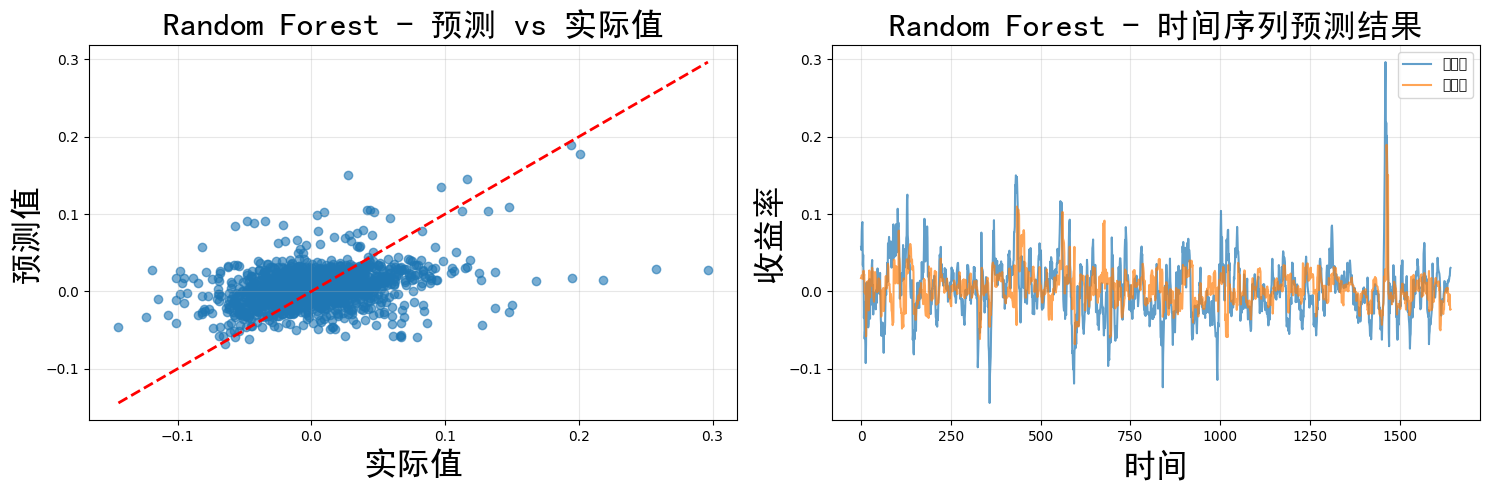

未来10天收益率预测: -0.0230 (-2.30%)
模型已保存: random_forest_model.pkl


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')




from matplotlib.font_manager import FontProperties
font = FontProperties(fname="/Users/minkexiu/Documents/GitHub/ML_Tryout/SimHei.ttf", size=24) 


class FundModelTrainer:
    def __init__(self, features_df, target_col='future_return_10d'):
        self.features_df = features_df
        self.target_col = target_col
        self.feature_cols = None
        self.scaler = None
        self.models = {}
        self.results = {}
        
    def prepare_data(self):
        exclude_cols = ['date', 'nav', 'daily_return',
                       'future_return_10d', 'future_return_10d_binary', 'future_return_10d_category']
        
        self.feature_cols = [col for col in self.features_df.columns if col not in exclude_cols]
        self.X = self.features_df[self.feature_cols].copy()
        self.y = self.features_df[self.target_col].copy()
        
        # 处理无穷大和NaN值
        self.X = self.X.replace([np.inf, -np.inf], np.nan)
        self.X = self.X.fillna(self.X.median())
        
        print(f"数据形状: {self.X.shape}")
        return self.X, self.y
    
    def scale_features(self, scaler_type='standard'):
        if scaler_type == 'standard':
            self.scaler = StandardScaler()
        
        self.X_scaled = self.scaler.fit_transform(self.X)
        return self.X_scaled
    
    def train_with_rolling_window(self, window_size=252, step_size=7):
        """使用滚动窗口训练模型"""
        print("使用滚动窗口训练模型...")
        
        models = {
            'Linear Regression': LinearRegression(),
            'Ridge Regression': Ridge(alpha=1.0),
            'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
            'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42, verbose=-1),
            'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42)
        }
        
        # 初始化结果存储
        for name in models.keys():
            self.results[name] = {
                'train_scores': [], 'val_scores': [], 'predictions': [], 'actuals': []
            }
        
        # 滚动窗口训练
        for i in range(window_size, len(self.X_scaled) - 10, step_size):
            # 训练集：前window_size个样本
            X_train = self.X_scaled[i-window_size:i]
            y_train = self.y.iloc[i-window_size:i]
            
            # 验证集：下一个step_size个样本
            val_end = min(i + step_size, len(self.X_scaled) - 10)
            X_val = self.X_scaled[i:val_end]
            y_val = self.y.iloc[i:val_end]
            
            # 训练模型
            for name, model in models.items():
                model.fit(X_train, y_train)
                
                # 预测验证集
                y_pred = model.predict(X_val)
                
                # 计算R²分数
                train_score = r2_score(y_train, model.predict(X_train))
                val_score = r2_score(y_val, y_pred)
                
                # 存储结果
                self.results[name]['train_scores'].append(train_score)
                self.results[name]['val_scores'].append(val_score)
                self.results[name]['predictions'].extend(y_pred)
                self.results[name]['actuals'].extend(y_val.values)
                
                # 保存最后一个模型
                self.models[name] = model
        
        # 计算平均性能
        for name in models.keys():
            avg_train_score = np.mean(self.results[name]['train_scores'])
            avg_val_score = np.mean(self.results[name]['val_scores'])
            mae = mean_absolute_error(self.results[name]['actuals'], self.results[name]['predictions'])
            rmse = np.sqrt(mean_squared_error(self.results[name]['actuals'], self.results[name]['predictions']))
            
            self.results[name]['avg_train_score'] = avg_train_score
            self.results[name]['avg_val_score'] = avg_val_score
            self.results[name]['mae'] = mae
            self.results[name]['rmse'] = rmse
        
        return self.results
    
    def evaluate_models(self):
        print("\n=== 模型评估结果 ===")
        
        eval_results = []
        for name, results in self.results.items():
            eval_results.append({
                'Model': name,
                'Avg Train R²': results['avg_train_score'],
                'Avg Val R²': results['avg_val_score'],
                'MAE': results['mae'],
                'RMSE': results['rmse']
            })
        
        eval_df = pd.DataFrame(eval_results)
        eval_df = eval_df.sort_values('Avg Val R²', ascending=False)
        print(eval_df.round(4))
        
        return eval_df
    
    def plot_predictions(self, model_name):
        if model_name not in self.results:
            print(f"模型 {model_name} 不存在")
            return
        
        results = self.results[model_name]
        
        plt.figure(figsize=(15, 5))
        
        # 预测 vs 实际值
        plt.subplot(1, 2, 1)
        plt.scatter(results['actuals'], results['predictions'], alpha=0.6)
        plt.plot([min(results['actuals']), max(results['actuals'])], 
                [min(results['actuals']), max(results['actuals'])], 'r--', lw=2)
        plt.xlabel('实际值',font=font)
        plt.ylabel('预测值',font=font)
        plt.title(f'{model_name} - 预测 vs 实际值', font=font)
        plt.grid(True, alpha=0.3)
        
        # 时间序列预测结果
        plt.subplot(1, 2, 2)
        plt.plot(results['actuals'], label='实际值', alpha=0.7)
        plt.plot(results['predictions'], label='预测值', alpha=0.7)
        plt.xlabel('时间',font=font)
        plt.ylabel('收益率',font=font)
        plt.title(f'{model_name} - 时间序列预测结果',font=font)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(f'{model_name}_predictions.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    def predict_future(self, model_name, latest_features):
        if model_name not in self.models:
            print(f"模型 {model_name} 不存在")
            return None
        
        model = self.models[model_name]
        latest_features = latest_features[self.feature_cols]
        
        if hasattr(self, 'scaler'):
            latest_features_scaled = self.scaler.transform(latest_features)
            prediction = model.predict(latest_features_scaled)
        else:
            prediction = model.predict(latest_features)
        
        return prediction[0]
    
    def save_model(self, model_name):
        import pickle
        filename = f"{model_name.replace(' ', '_').lower()}_model.pkl"
        with open(filename, 'wb') as f:
            pickle.dump(self.models[model_name], f)
        print(f"模型已保存: {filename}")
        return filename

def main():
    from fund_feature_generator import FundFeatureGenerator
    
    generator = FundFeatureGenerator(fund_code="004746")
    features_df = generator.generate_all_features(target_days=10)
    
    trainer = FundModelTrainer(features_df)
    X, y = trainer.prepare_data()
    X_scaled = trainer.scale_features()
    results = trainer.train_with_rolling_window()
    
    eval_df = trainer.evaluate_models()
    
    best_model = eval_df.iloc[0]['Model']
    trainer.plot_predictions(best_model)
    
    latest_data = features_df.iloc[-1:][trainer.feature_cols]
    future_prediction = trainer.predict_future(best_model, latest_data)
    print(f"未来10天收益率预测: {future_prediction:.4f} ({future_prediction*100:.2f}%)")
    
    trainer.save_model(best_model)
    
    return trainer, eval_df

if __name__ == "__main__":
    trainer, eval_df = main() 